In [ ]:
#Each cell block works as standalone code. All the models generate respective csv file with the model name as the file name
#
#Block 1: Data Exploration
#Block 2: Linear Regression Model
#Block 3: AR Model
#Block 4: MA Model
#Block 5: ARMA Model
#Block 6: ARIMA Model
#Block 7: Seasonal ARIMA Model
#Block 8: LightGBM Model
#Block 9: RNN/LSTM Model

(0, 200000)

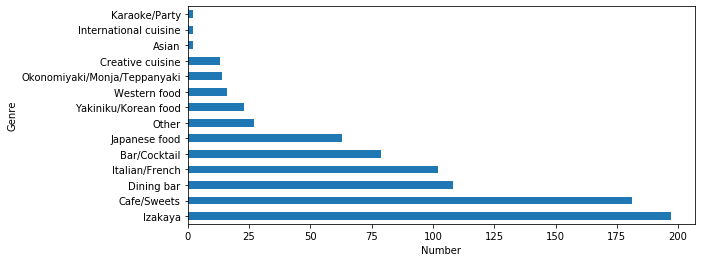

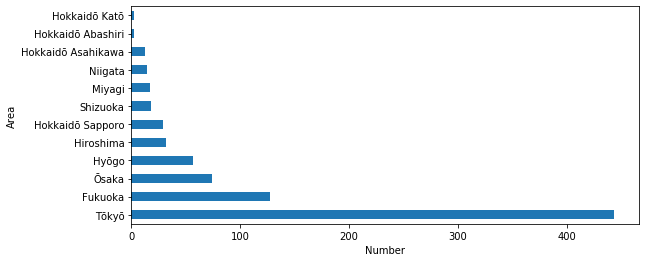

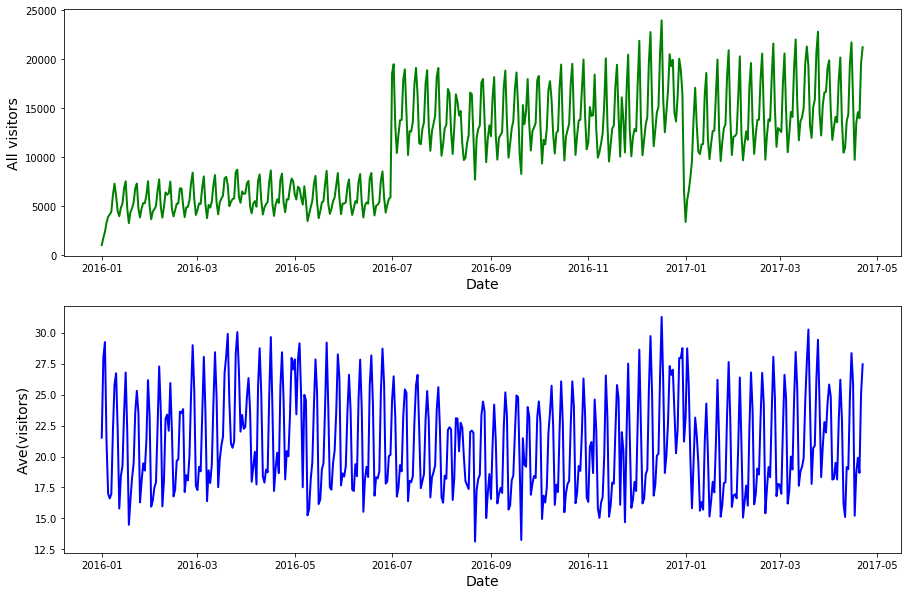

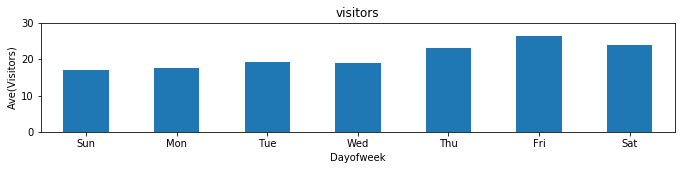

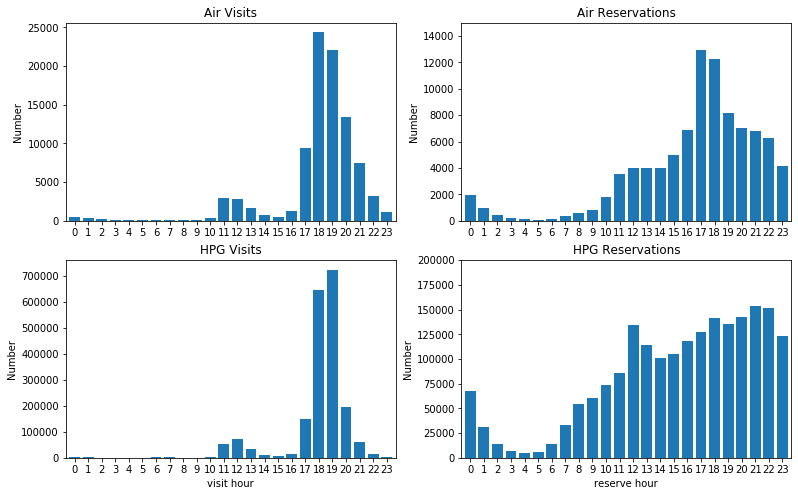

In [2]:
### DATA EXPLORATION ###

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import seaborn as sns

#Loading the data
air_visit = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
air_store = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_store_info.csv')
hpg_store = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
air_reserve = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_reserve.csv')
hpg_reserve = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
store_id = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/store_id_relation.csv')
holiday = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/date_info.csv').rename(columns={'calendar_date':'visit_date'})
sub = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')

#Genre Plot
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
temp=air_store.groupby("air_genre_name").count()['air_store_id'].sort_values(ascending=False)
temp.plot(kind='barh',width=0.5,ax=ax)
ax.set_yticklabels(temp.sort_values(ascending=False).index,fontsize=10)
plt.xlabel("Number",fontsize=10)
plt.ylabel("Genre",fontsize=10)

#Area Plot
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
air_store[['air_area']] = air_store.air_area_name.apply( 
   lambda x: pd.Series(split(str(x), "-", 1)[0]))
air_store = air_store.drop(columns=['air_area_name'])
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(121)
temp=air_store.groupby("air_area").count()['air_store_id'].sort_values(ascending=False)
temp.plot(kind='barh',width=0.5,ax=ax)
ax.set_yticklabels(temp.sort_values(ascending=False).index,fontsize=10)
plt.xlabel("Number",fontsize=10)
plt.ylabel("Area",fontsize=10)

#Visitors Plot
air_visit['visit_date']=pd.to_datetime(air_visit['visit_date'])
air_visit['visit_date']
###Plot1
figure = plt.figure(figsize=(15,10))
ax1 = figure.add_subplot(211)
temp = air_visit.groupby(['visit_date']).sum()
ax1.plot(temp,'green',linewidth=2)
ax1.set_xlabel('Date',fontsize=14)
ax1.set_ylabel('All visitors',fontsize=14)
###Plot2
ax2 = figure.add_subplot(212)
temp = air_visit.groupby(['visit_date']).mean()
ax2.plot(temp.index,temp.values,'blue',linewidth=2)
ax2.set_xlabel('Date',fontsize=14)
ax2.set_ylabel('Ave(visitors)',fontsize=14)

#Visitors by week days
fig = plt.figure(figsize=(25,2))
ax = fig.add_subplot(121)
air_visit["dayofweek"] = air_visit.visit_date.dt.dayofweek
day_p=air_visit.groupby("dayofweek").mean()['visitors']
day_p.plot(kind='bar', figsize=(12,2), legend=None, 
           subplots=True, ax=ax, use_index=False, linewidth=3)
plt.ylim(0,30)
plt.ylabel("Ave(Visitors)",fontsize=10)
plt.xlabel("Dayofweek",fontsize=10)
ax.set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=10)
plt.xticks(rotation=0)

#Visit and Reservation Plot
air_reserve['visit_datetime']=pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime']=pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['visit_hour']=air_reserve['visit_datetime'].dt.hour
air_reserve['reserve_hour']=air_reserve['reserve_datetime'].dt.hour
hpg_reserve['visit_datetime']=pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime']=pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['visit_hour']=hpg_reserve['visit_datetime'].dt.hour
hpg_reserve['reserve_hour']=hpg_reserve['reserve_datetime'].dt.hour
fig = plt.figure(figsize=(13,8))
ax=fig.add_subplot(221)
air_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                   width=0.8, 
                                                                   ax=ax)
plt.xlabel("",fontsize=10)
plt.ylabel("Number",fontsize=10)
plt.title("Air Visits")
plt.xticks(rotation=0)
ax2=fig.add_subplot(222)
air_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                     width=0.8, 
                                                                     ax=ax2)
plt.xlabel("",fontsize=10)
plt.ylabel("Number",fontsize=10)
plt.title("Air Reservations")
plt.ylim(0,15000)
plt.xticks(rotation=0)
ax3=fig.add_subplot(223)
hpg_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                   width=0.8, 
                                                                   ax=ax3)
plt.xlabel("visit hour",fontsize=10)
plt.ylabel("Number",fontsize=10)
plt.title("HPG Visits")
plt.xticks(rotation=0)
ax4=fig.add_subplot(224)
hpg_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                     width=0.8, 
                                                                     ax=ax4)
plt.xlabel("reserve hour",fontsize=10)
plt.ylabel("Number",fontsize=10)
plt.title("HPG Reservations")
plt.xticks(rotation=0)
plt.ylim(0,200000)

In [3]:
### LINEAR REGRESSION MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math

#Pre-processing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Create separate columns for date data
df['Year'] = pd.DatetimeIndex(df['visit_date']).year
df['Month'] = pd.DatetimeIndex(df['visit_date']).month
df['Day'] = pd.DatetimeIndex(df['visit_date']).day
###Remove unnecessary restaurant data
lst = df[df['visit_date'] >= '2017-04-23'].air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])
###Add date info data
date_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/date_info.csv')
day = {'Monday': 1,'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
date_df.day_of_week = [day[item] for item in date_df.day_of_week] 
subDF = pd.merge(subDF, date_df, left_on='visit_date', right_on='calendar_date')
###Add reservation data
reserve_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_reserve.csv')
hpg_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
rel_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/store_id_relation.csv')
sub_hpg = pd.merge(hpg_df, rel_df, left_on='hpg_store_id', right_on='hpg_store_id')
n = reserve_df.append(sub_hpg.drop(columns=['hpg_store_id']))
n.index = pd.to_datetime(n['visit_datetime'])
nx = n.groupby('air_store_id').apply(lambda g: g['reserve_visitors'].resample('D').sum()).reset_index()
subDF['visit_date'] = pd.to_datetime(subDF['visit_date'])
subDF = pd.merge(subDF, nx, left_on=['air_store_id','visit_date'], right_on=['air_store_id','visit_datetime'], how='left')
subDF = subDF.drop(columns=['visit_datetime'])
subDF = subDF.fillna(0)
subDF['reserve_visitors_org'] = subDF['reserve_visitors']
subDF['reserve_visitors'] = np.log1p(subDF['reserve_visitors'])

#Regression model
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
i=0
rmse = []
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org','calendar_date','reserve_visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org','calendar_date','reserve_visitors_org'])]
    regressor = LinearRegression()  
    regressor.fit(train_df.loc[:, train_df.columns != 'visitors'], train_df['visitors'])
    test_df['visitors'] = regressor.predict(test_df.loc[:, ~test_df.columns.isin(['air_store_id','visitors','visit_date'])])
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('regression.csv', index=False)

C:\Users\VineetJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\VineetJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\VineetJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

1
air_00a91d42b08b08d9
2
air_0164b9927d20bcc3
3
air_0241aa3964b7f861
4
air_0328696196e46f18
5
air_034a3d5b40d5b1b1
6
air_036d4f1ee7285390
7
air_0382c794b73b51ad
8
air_03963426c9312048
9
air_04341b588bde96cd
10
air_049f6d5b402a31b2
11
air_04cae7c1bc9b2a0b
12
air_0585011fa179bcce
13
air_05c325d315cc17f5
14
air_0647f17b4dc041c8
15
air_064e203265ee5753
16
air_066f0221b8a4d533
17
air_06f95ac5c33aca10
18
air_0728814bd98f7367
19
air_0768ab3910f7967f
20
air_07b314d83059c4d2
21
air_07bb665f9cdfbdfb
22
air_082908692355165e
23
air_083ddc520ea47e1e
24
air_0845d8395f30c6bb
25
air_084d98859256acf0
26
air_0867f7bebad6a649
27
air_08ba8cd01b3ba010
28
air_08cb3c4ee6cd6a22
29
air_08ef81d5b7a0d13f
30
air_08f994758a1e76d4
31
air_09040f6df960ddb8
32
air_0919d54f0c9a24b8
33
air_09661c0f3259cc04
34
air_09a845d5b5944b01
35
air_09fd1f5c58583141
36
air_0a74a5408a0b8642
37
air_0b184ec04c741a6a
38
air_0b1e72d2d4422b20
39
air_0b9038300f8b2b50
40
air_0e1eae99b8723bc1
41
air_0e7c11b9abc50163
42
air_0f0cdeee6c9bf3d7
4

In [ ]:
### AR MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
subm = df[df['visit_date'] >= '2017-04-23'].copy()
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Remove unnecessary restaurant data
lst = subm.air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])

#AR model
i=0
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org'])]
    model = pm.auto_arima(train_df.visitors, start_p=1, start_q=0,
                      test='adf',       
                      max_p=5, max_q=0, 
                      m=1,              
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    n_periods = 39
    fc = model.predict(n_periods=n_periods)
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    test_df['visitors'] = fc
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('file_AR.csv', index=False)

In [ ]:
### MA MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
subm = df[df['visit_date'] >= '2017-04-23'].copy()
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Remove unnecessary restaurant data
lst = subm.air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])

#MA model
i=0
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org'])]
    model = pm.auto_arima(train_df.visitors, start_p=0, start_q=1,
                      test='adf',       
                      max_p=0, max_q=5, 
                      m=1,              
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    n_periods = 39
    fc = model.predict(n_periods=n_periods)
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    test_df['visitors'] = fc
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('file_MA.csv', index=False)

In [ ]:
### ARMA MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
subm = df[df['visit_date'] >= '2017-04-23'].copy()
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Remove unnecessary restaurant data
lst = subm.air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])

#ARMA model
i=0
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org'])]
    model = pm.auto_arima(train_df.visitors, start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=1,              
                      d=0,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    n_periods = 39
    fc = model.predict(n_periods=n_periods)
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    test_df['visitors'] = fc
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('file_ARMA.csv', index=False)

In [ ]:
### ARIMA MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
subm = df[df['visit_date'] >= '2017-04-23'].copy()
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Remove unnecessary restaurant data
lst = subm.air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])

#ARIMA model
i=0
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org'])]
    model = pm.auto_arima(train_df.visitors, start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=1,              
                      d=None,        #best d-value decided by function  
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    n_periods = 39
    fc = model.predict(n_periods=n_periods)
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    test_df['visitors'] = fc
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('file_ARIMA.csv', index=False)

In [ ]:
### SEASONAL ARIMA MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn import metrics
import math
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge submission and visit data
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
subm = df[df['visit_date'] >= '2017-04-23'].copy()
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Remove unnecessary restaurant data
lst = subm.air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
subDF['visitors_org'] = subDF['visitors']
subDF['visitors'] = np.log1p(subDF['visitors'])

#Seasonal ARIMA model
i=0
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    train_df = dr.loc[dr.visit_date < '2017-04-23', ~dr.columns.isin(['air_store_id','visitors_org'])]
    train_df.set_index('visit_date', inplace=True)
    test_df = dr.loc[dr.visit_date >= '2017-04-23', ~dr.columns.isin(['visitors_org'])]
    model = pm.auto_arima(train_df.visitors, start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=7,              
                      d=None,        #Best d-value decided by function  
                      seasonal=True,   
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    n_periods = 39
    fc = model.predict(n_periods=n_periods)
    test_df['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    test_df['visitors'] = fc
    dfObjSubm = pd.concat([dfObjSubm, test_df[['id','visitors']]])
dfObjSubm['visitors'] = round(np.expm1(dfObjSubm['visitors']))
dfObjSubm = dfObjSubm.reset_index(drop=True)
dfObjSubm.to_csv('file_SARIMA.csv', index=False)

In [4]:
### LIGHTGBM MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math

#Preprocessing
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###Merge air_visit_data with sample_submission
df_sub =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub = df_sub.drop(columns=['id'])
df = pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample date and fill missing values with median
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
###Create separate date column values
df['Year'] = pd.DatetimeIndex(df['visit_date']).year
df['Month'] = pd.DatetimeIndex(df['visit_date']).month
df['Day'] = pd.DatetimeIndex(df['visit_date']).day
###Remove extra data
lst = df[df['visit_date'] >= '2017-04-23'].air_store_id.unique()
subDF = df[df['air_store_id'].isin(lst)]
###Take log1p for visitors
subDF['visitors'] = np.log1p(subDF['visitors'])
###Add date_info data
date_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/date_info.csv')
day = {'Monday': 1,'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
date_df.day_of_week = [day[item] for item in date_df.day_of_week] 
subDF = pd.merge(subDF, date_df, left_on='visit_date', right_on='calendar_date')
###Add reserve data for air and hpg
reserve_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_reserve.csv')
hpg_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
rel_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/store_id_relation.csv')
sub_hpg = pd.merge(hpg_df, rel_df, left_on='hpg_store_id', right_on='hpg_store_id')
n = reserve_df.append(sub_hpg.drop(columns=['hpg_store_id']))
n.index = pd.to_datetime(n['visit_datetime'])
nx = n.groupby('air_store_id').apply(lambda g: g['reserve_visitors'].resample('D').sum()).reset_index()
subDF['visit_date'] = pd.to_datetime(subDF['visit_date'])
subDF = pd.merge(subDF, nx, left_on=['air_store_id','visit_date'], right_on=['air_store_id','visit_datetime'], how='left')
###Remove unnecessary columns and fill missing reserve data values with 0
subDF = subDF.drop(columns=['visit_datetime','calendar_date'])
subDF = subDF.fillna(0)
subDF['reserve_visitors'] = np.log1p(subDF['reserve_visitors'])
###Add store info data
air_df =pd.read_csv('E:/R workspace/recruit-restaurant-visitor-forecasting/air_store_info.csv')
air_df[['air_area']] = air_df.air_area_name.apply( 
   lambda x: pd.Series(split(str(x), "-", 1)[0]))
air_df = air_df.drop(columns=['air_area_name'])
newDF = pd.merge(subDF, air_df, left_on='air_store_id', right_on='air_store_id', how='left')
###Add average visitor and reservation data by genre
avg = newDF[['air_genre_name','visitors','reserve_visitors']].groupby('air_genre_name').mean()
avg = avg.rename(columns={"visitors": "mean_visitors", "reserve_visitors": "mean_reserve_visitors"})
avgData = pd.merge(newDF, avg, left_on='air_genre_name', right_on='air_genre_name')
###Add average visitor and reservation data by area
avgAr = newDF[['air_area','visitors','reserve_visitors']].groupby('air_area').mean()
avgAr = avgAr.rename(columns={"visitors": "mean_visitors_area", "reserve_visitors": "mean_reserve_visitors_area"})
avgArData = pd.merge(avgData, avgAr, left_on='air_area', right_on='air_area')
###One hot encoding for genre and area
enc = pd.get_dummies(avgArData, columns=["air_genre_name","air_area"], prefix=["genre", "area"])
enc.columns = enc.columns.str.replace("/", "_")
enc.columns = enc.columns.str.replace(" ", "_")
enc = enc.rename(columns={"area_Hokkaidō_Abashiri": "area_Hokkaido_Abashiri", "area_Hokkaidō_Asahikawa": "area_Hokkaido_Asahikawa", "area_Hokkaidō_Katō": "area_Hokkaido_Kato", "area_Hokkaidō_Sapporo": "area_Hokkaido_Sapporo", "area_Hyōgo": "area_Hyogo", "area_Tōkyō": "area_Tokyo", "area_Ōsaka": "area_Osaka"})

#LightGBM model
from datetime import datetime
import lightgbm as lgb
col = [f for f in enc.columns if f not in (['air_store_id','visit_date','visitors'])]
train_df = enc[enc.visit_date < '2017-04-23']
test_df = enc[enc.visit_date >= '2017-04-23']
params = {
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.9,
    'num_leaves': 100,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}
t0 = datetime.now()
lgb_train = lgb.Dataset(train_df[col], train_df['visitors'])
lgb_test = lgb.Dataset(test_df[col], test_df['visitors'])
gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test_df[col])
t1 = datetime.now()
diff = t1 - t0
print(diff)
res = pd.DataFrame()
res['id'] = test_df.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
res['visitors'] = np.expm1(pred)
res['visitors'] = round(res['visitors'])
res.to_csv('lightgbm.csv',index=False)

C:\Users\VineetJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\VineetJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0:00:55.840578


In [ ]:
### RNN/LSTM MODEL ###

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Preprocessing
###Random seed for reproducibility
np.random.seed(7)
###A function to split a string based on seprator and position of separator
def split(strng, sep, pos):
    strng = strng.split(sep)
    return sep.join(strng[:pos]), sep.join(strng[pos:])
###A function to convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
###Merge submission and visit data
df_sub =pd.read_csv('C:/Users/Akshay/Documents/Rashi/recruit-restaurant-visitor-forecasting/sample_submission.csv')
df_sub[['air_store_id','visit_date']] = df_sub.id.apply( 
   lambda x: pd.Series(split(str(x), "_", 2))) 
df_sub.drop(columns=['id'])
lst = df_sub.air_store_id.unique()
df = pd.read_csv('C:/Users/Akshay/Documents/Rashi/recruit-restaurant-visitor-forecasting/air_visit_data.csv')
medianValue = round(df['visitors'].median())
df = df.append(df_sub, ignore_index=True, sort=False)
###Resample dates and perform median imputation
df.index = pd.to_datetime(df['visit_date'])
df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('D').sum()).reset_index()
df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
mask = (df['visitors'] == 0) & (df['visit_date'] < '2017-04-23')
df['visitors'][mask] = medianValue
subDF = df

#RNN/LSTM model
i=0
look_back = 7
dfObjSubm = pd.DataFrame(columns=['id', 'visitors'])
for item in lst:
    i+=1
    print(i)
    print(item)
    dr = subDF[subDF['air_store_id'] == item] 
    df_result = dr[dr['visit_date'] >= '2017-04-23']
    dataset = dr['visitors'][dr['visit_date'] < '2017-04-23']
    dataset = dataset.values
    dataset = dataset.astype('float32')
    #Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
    #Split into train and test data
    train, test = dataset[0:len(dataset),:], dataset[(len(dataset)-look_back-40):len(dataset),:]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    #Reshape input according to model requirement
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    #Predict the output
    testPredict = model.predict(testX)
    #Invert predictions
    testPredict = scaler.inverse_transform(testPredict)
    df_result['id'] = df_result.apply(lambda row: row.air_store_id +'_'+ str(row.visit_date).split()[0], axis=1)
    df_result['visitors'] = testPredict
    dfObjSubm = pd.concat([dfObjSubm, df_result[['id','visitors']]])    
dfObjSubm['visitors'] = round(dfObjSubm['visitors'])
dfObjSubm = dfObjSubm.reset_index(drop=True)
print(dfObjSubm)
dfObjSubm.to_csv('file_LSTM.csv', index=False)